In [19]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random
import itertools

In [23]:
def argsmax(A):

    if type(A) == dict:
        return {i for i, a in A.items() if a == max(A.values())}

    if type(A) == list:
        return argsmax(dict(enumerate(A)))

    return None

In [43]:
colors = {
    'values': {
        'border': (0, 0, 0),
        'track': (255, 255, 255),
        'starting line': (255, 0, 0),
        'finish line': (0, 255, 0)
    },
    'names': {
        'border': 'black',
        'track': 'white',
        'starting line': 'red',
        'finish line': 'green'
    }
}

In [57]:
class Racetrack():


    actions_max = set(
        [np.array(action) for action in itertools.product(range(-1, 2), range(-1, 2))]
    )

    velocities_max = set(
        [np.array(velocity) for velocity in itertools.product(range(5), range(5))]
    )
    velocities_max.remove(np.zeros(2))


    episode_length_max = 1_000


    def __init__(self, file_name):

        self.file_name = file_name
        self.image = Image.open(self.file_name)

        self.size = self.image.size
        self.x_max, self.y_max = self.size

        self.load_image()


    def load_image(self):

            self.layout = {
                'border': [],
                'track': [],
                'starting line': [],
                'finish line': []
            }

            for x, y in self.positions_max():

                color = self.image.getpixel((x, y))

                for layout_part, layout_part_color in colors['values'].items():
                    if color == layout_part_color:
                        self.layout[layout_part].append((x, y))

    def plot(self):

        plt.figure(figsize = (5, 5))

        for layout_part, layout_part_color in colors['names'].items():

            x, y = np.array(self.layout[layout_part]).T

            plt.scatter(
                x, self.y_max - 1 - y, color = layout_part_color, marker = 's'
            )

        plt.show()

    def positions_max(self):
        return {
            np.array(position)
            for position in itertools.product(
                range(x_max), range(y_max)
            )
        }

    def states_max(self):
        return itertools.product(
            self.positions_max(), Racetrack.velocities_max
        )

    def actions(self, state):
        return {
            delta for delta in Racetrack.actions_max if state[1] + delta in Racetrack.actions_max
        }


    def monte_carlo(self, gamma = 0.9, episodes = 10):

        # Initialize:
        pi = {
            state: random.choice(self.actions(state))
            for state in self.states_max()
        }
        Q = {
            state: {
                action: random.random()
                for action in self.actions(state)
            }
            for state in self.states_max()
        }
        Returns = {
            state: {
                action: []
                for action in self.actions(state)
            }
            for state in self.states_max()
        }

        # Loop forever (for each episode):
        for episode in range(episodes):

            S = [
                (
                    random.choice(self.layout['starting line']),
                    np.zeros(2)
                )
            ]
            A = [
                random.choice(self.actions(S[-1]))
            ]
            R = [] # starts indexing at 0

            # Generate an episode from $S_0$, $A_0$, following $\pi: S_0, A_0, R_1, \dots, S_{T-1}, A_{T-1}, R_T$
            for t in range(Racetrack.episode_length_max):

                velocity_new = S[-1][1] + pi[S[-1]]
                S[-1][0] + velocity_new

                if position_new in self.layout['finishing line']:
                    R.append(1)
                    break
                elif position_new in self.layout['starting line'] or position_new in self.layout['track']:
                    R.append(0)
                    S.append(
                        (
                            position_new,
                            velocity_new
                        )
                    )
                    A.append(pi[S[-1]])
                else:
                    R.append(-1)
                    break

            assert len(S) == len(A) == len(R)

            G = 0
            T = len(S)

            for t in range(T-1, 0-1, -1):

                G = gamma * G + R[t]

                S_ = S[t]
                A_ = A[t]

                if not (S_, A_) in zip(S[:t], A[:t]):

                    Returns[S_][A_].append(G)
                    Q[S_][A_] = np.average(Returns[S_][A_])
                    pi[S_] = argmax(Q[S_])

        return pi

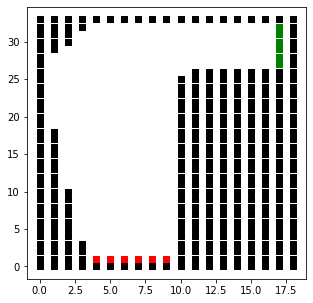

In [58]:
my_racetrack = Racetrack('map_1.png')
my_racetrack.plot()